In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
%matplotlib inline

from wordsegment import load, segment
load()

import nltk

np.random.seed(123)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv


In [2]:
df=pd.read_csv(r'/kaggle/input/nlp-getting-started/train.csv')
df_test=pd.read_csv(r'/kaggle/input/nlp-getting-started/test.csv')

In [3]:
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [4]:
#code taken from this website 
#https://towardsdatascience.com/how-i-improved-my-text-classification-model-with-feature-engineering-98fbe6c13ef3

df['uppercase']=df['text'].str.count(r'[A-Z]')
df['word_count']=df['text'].apply(lambda x: len(x.split()))
df['char_count']=df['text'].apply(lambda x: len(x.replace(" ","")))
df['word_density']=df['word_count']/(df['char_count'] + 1)
df['punc_count']=df['text'].apply(lambda x : len([a for a in x if a in string.punctuation]))
df['total_length'] = df['text'].apply(len)
df['caps_vs_length'] = df.apply(lambda row: float(row['uppercase'])/float(row['total_length']),axis=1)
df['num_exclamation_marks'] =df['text'].apply(lambda x: x.count('!'))
df['num_question_marks'] = df['text'].apply(lambda x: x.count('?'))
df['num_hashtags'] = df['text'].apply(lambda x: x.count('#'))
df['num_punctuation'] = df['text'].apply(lambda x: sum(x.count(w) for w in '.,;:'))
df['num_symbols'] = df['text'].apply(lambda x: sum(x.count(w) for w in '*&$%'))
df['total_punctuation']=df['text'].apply(lambda x: sum(x.count(w) for w in "#!?'.,;:"))
df['total_numbers']=df['text'].str.count(r'[0-9]')

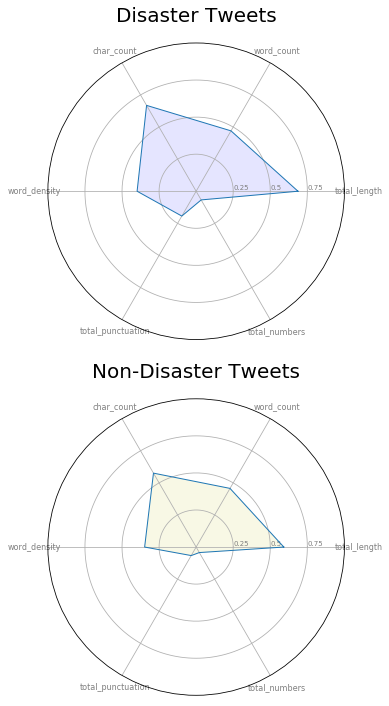

In [5]:
from math import pi

categories=['total_length','word_count','char_count','word_density','total_punctuation', 'total_numbers']
N = len(categories)

df_target=df[df['target']==1]

values_target=df_target[['total_length','word_count','char_count','word_density',
                         'total_punctuation', 'total_numbers']].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0).mean(axis=0).values.flatten().tolist()
values_target += values_target[:1]

df_non_target=df[df['target']==0]

values_non_target=df_non_target[['total_length','word_count','char_count','word_density',
                                 'total_punctuation','total_numbers']].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0).mean(axis=0).values.flatten().tolist()
values_non_target += values_non_target[:1]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(16,12))
ax = plt.subplot(211, polar=True)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Give title
ax.set_title('Disaster Tweets', fontsize=20)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="grey", size=7)
plt.ylim(0,1)

# Plot data
ax.plot(angles, values_target, linewidth=1, linestyle='solid')

# Fill area
ax.fill(angles, values_target, 'b', alpha=0.1)

ax = plt.subplot(212, polar=True)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Give title
ax.set_title('Non-Disaster Tweets', fontsize=20)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.25,0.5,0.75], ["0.25","0.5","0.75"], color="grey", size=7)
plt.ylim(0,1)

# Plot data
ax.plot(angles, values_non_target, linewidth=1, linestyle='solid')

# Fill area
ax.fill(angles, values_non_target, 'y', alpha=0.1)


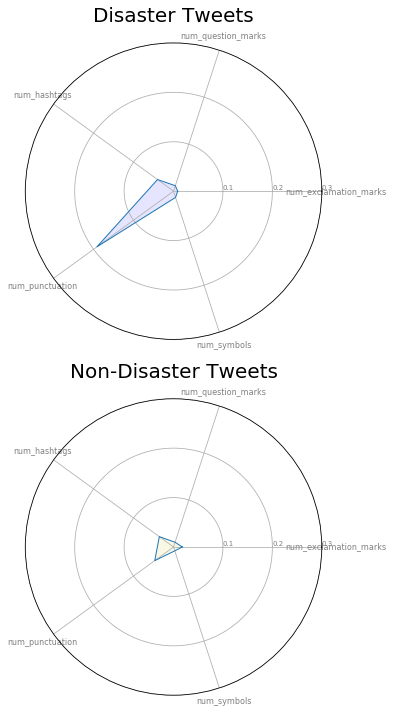

In [6]:
categories=['num_exclamation_marks',
       'num_question_marks', 'num_hashtags', 'num_punctuation', 'num_symbols']
N = len(categories)

df_target=df[df['target']==1]

values_target=df_target[categories].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)\
    .mean(axis=0).values.flatten().tolist()
values_target += values_target[:1]

df_non_target=df[df['target']==0]

values_non_target=df_non_target[categories].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)\
    .mean(axis=0).values.flatten().tolist()
values_non_target += values_non_target[:1]

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(16,12))
ax = plt.subplot(211, polar=True)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Give title
ax.set_title('Disaster Tweets', fontsize=20)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.2,0.3], ["0.1","0.2", "0.3"], color="grey", size=7)
plt.ylim(0,0.3)

# Plot data
ax.plot(angles, values_target, linewidth=1, linestyle='solid')

# Fill area
ax.fill(angles, values_target, 'b', alpha=0.1)

ax = plt.subplot(212, polar=True)

# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='grey', size=8)

# Give title
ax.set_title('Non-Disaster Tweets', fontsize=20)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.1,0.2,0.3], ["0.1","0.2", "0.3"], color="grey", size=7)
plt.ylim(0,0.3)

# Plot data
ax.plot(angles, values_non_target, linewidth=1, linestyle='solid')

# Fill area
ax.fill(angles, values_non_target, 'y', alpha=0.1)

[Text(0.5, 0, 'char_count'),
 Text(1.5, 0, 'total_length'),
 Text(2.5, 0, 'total_punctuation'),
 Text(3.5, 0, 'num_punctuation')]

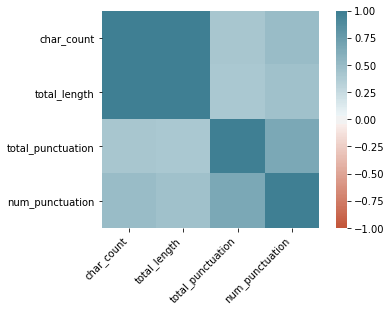

In [7]:
import seaborn as sns

corr = df[['char_count','total_length','total_punctuation', 'num_punctuation']].corr() 
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True) 

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')

In [8]:
def remove_hashtags(text):
    text_list=text.split()
    for word in text_list:
        if word.startswith("#"):
            text_list+=segment(word)
            text_list.remove(word)
    return text_list

df['cleaned_txt']=df['text'].apply(remove_hashtags).str.join(" ")
df['cleaned_txt']=df['cleaned_txt'].str.replace(r'^https?:\/\/.*[\r\n]*', '')

In [9]:
from bs4 import BeautifulSoup

stops_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", 
             "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", 
             "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
             "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", 
             "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", 
             "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", 
             "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", 
             "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", 
             "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", 
             "just", "don", "should", "now", "may", "m", "co", "http", "https", "amp"]

def clean_txt(raw_txt, stops=stops_words):
    # Function to clean raw text
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_txt) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    stops = set(stops)                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words )) 

df['no_punc_txt']=df['cleaned_txt'].apply(clean_txt)

In [10]:
#top 30 words with target=1
df[df['target']==1]['no_punc_txt'].str.split(expand=True).stack().value_counts()[:29]

news          197
fire          196
disaster      121
via           121
california    115
suicide       111
police        110
people        108
u             101
storm          99
like           96
hiroshima      94
pm             92
killed         87
fires          86
p              81
families       81
w              79
train          79
bomb           79
d              79
crash          79
emergency      76
r              75
buildings      75
nuclear        74
two            74
mh             74
attack         72
dtype: int64

In [11]:
#top 30 words with target=0
df[df['target']==0]['no_punc_txt'].str.split(expand=True).stack().value_counts()[:29]

like         255
new          172
get          163
one          134
re           122
u            117
body         116
d            105
w            103
would        101
via           99
video         99
love          96
people        95
o             93
day           87
time          87
know          86
us            86
back          85
got           85
full          84
see           81
x             80
emergency     79
going         76
youtube       76
let           76
still         72
dtype: int64

In [12]:
disaster_words=['zap','windy','windstorm','wind','whirlwind',
'whirlpool','wave','volt','volcano','uproot','underground','twister','tsunami', 'typhoon',
'tremor','tree', 'train', 'touchdown','tornado','thunderstorm','tension', 
'stuck','storm','spill','snowstorm','sinking','sink','shelter','seismic', 'suicide',
'sea', 'scientist', 'science', 'sandstorm', 'river','rescue','rainstorm',
'rain', 'poverty', 'poor', 'permafrost', 'oil', 'ocean','nightmare',
'myth', 'mountain', 'monstrosity', 'monster', 'money', 'magma','low',
'lost', 'lightning','life','lava','lack', 'impoverish','iceberg','ice','hurricane',
'pressure', 'heat', 'hailstorm', 'hail', 'gust', 'god', 'geyser', 'gale', 'gas', 'forest',
'force', 'fog', 'flood', 'fire', 'fault','fate','fatality','fatal','farm','erosion', 'explode', 'emergency',
'earthquake','drought','disaster','destruction','destroy','death','damage','dam', 'crash',
'cyclone','cataclysm','car','casualty','blizzard','blackout', 'barometer', 'bomb', 'building', 'attack',
'avalanche','arson','wind scale','violent','richterscale', 'dead'
'heat','forest fire','dust', 'breaking', 'news', 'gun', 'shot', 'aircraft', 'kill', 'police']

In [13]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
   
lemmatizer=WordNetLemmatizer()

In [14]:
df['no_punc_txt_tok']=df['no_punc_txt'].str.split()
df['lemm_txt']=df['no_punc_txt_tok'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

In [15]:
from nltk.corpus import wordnet 

#manywords = nltk.corpus.words.words() + nltk.corpus.wordnet.words() 
words = set(nltk.corpus.wordnet.words())

def nonsense_word(text):
    return [w for w in text if w in words]

df['only_eng_words']=df['lemm_txt'].apply(nonsense_word)
df['no_of_eng_words']=[len(x) for x in df['only_eng_words']]

In [16]:
def nonsense_word_finder(text):
    return [w for w in text if w not in words]

df['nonsense_words']=df['lemm_txt'].apply(nonsense_word_finder)
df['no_of_nonsense_words']=[len(x) for x in df['nonsense_words']]

In [17]:
df['full_lemm_txt']=df['lemm_txt'].apply(lambda x: " ".join(x))

In [18]:
disaster_words=set([lemmatizer.lemmatize(y) for y in disaster_words])
print(disaster_words)

{'life', 'explode', 'damage', 'sinking', 'blackout', 'tremor', 'sink', 'hailstorm', 'whirlpool', 'dust', 'sandstorm', 'breaking', 'poor', 'gale', 'pressure', 'myth', 'police', 'whirlwind', 'suicide', 'stuck', 'aircraft', 'wind scale', 'windy', 'volcano', 'typhoon', 'scientist', 'zap', 'wind', 'magma', 'destruction', 'spill', 'forest', 'bomb', 'flood', 'monstrosity', 'impoverish', 'fatal', 'earthquake', 'death', 'seismic', 'oil', 'cataclysm', 'nightmare', 'farm', 'rain', 'attack', 'money', 'shot', 'iceberg', 'river', 'casualty', 'tornado', 'force', 'lava', 'windstorm', 'low', 'news', 'god', 'shelter', 'drought', 'tsunami', 'deadheat', 'blizzard', 'monster', 'fire', 'violent', 'hail', 'gun', 'volt', 'tree', 'ice', 'building', 'crash', 'thunderstorm', 'science', 'touchdown', 'cyclone', 'storm', 'kill', 'richterscale', 'heat', 'gas', 'wave', 'poverty', 'rainstorm', 'geyser', 'lack', 'train', 'fog', 'forest fire', 'erosion', 'dam', 'ocean', 'sea', 'fault', 'avalanche', 'emergency', 'lightni

In [19]:
df['contains_disaster']=df['full_lemm_txt'].str.contains('|'.join(list(disaster_words)))
df['no_of_disaster_words']=df['full_lemm_txt'].str.count('|'.join(list(disaster_words)))

Text(0.5, 1.0, 'Proportion of Nonsense words vs word length between Disaster Tweets vs Non-Disaster Tweets')

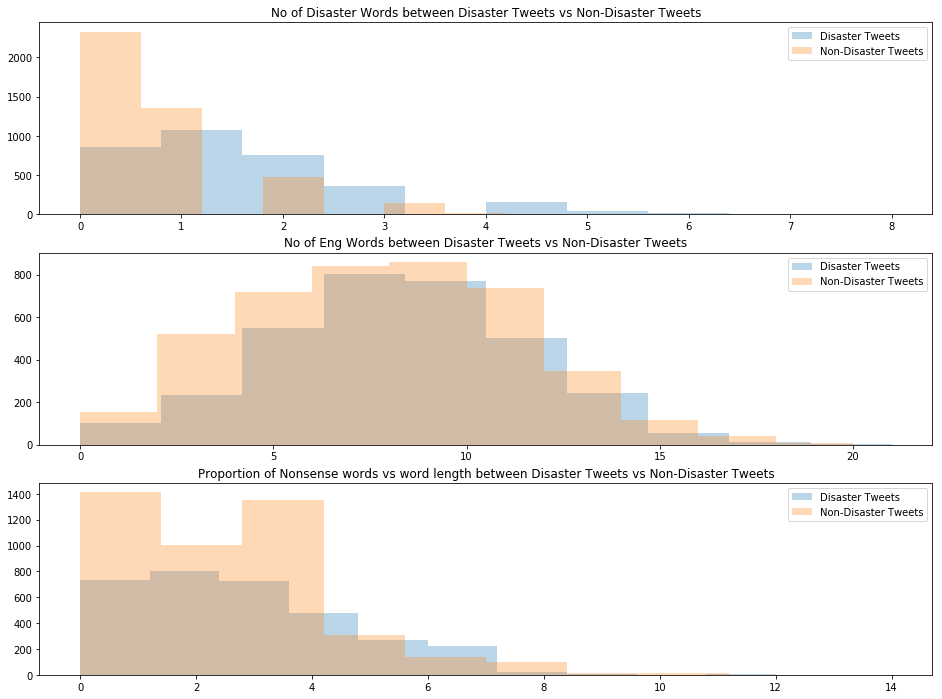

In [20]:
plt.figure(figsize=(16,12))
ax = plt.subplot(311)

plt.hist(df[df['target']==1]['no_of_disaster_words'], alpha=0.3, label="Disaster Tweets")
plt.hist(df[df['target']==0]['no_of_disaster_words'], alpha=0.3, label="Non-Disaster Tweets")
plt.legend(loc="upper right")
plt.title("No of Disaster Words between Disaster Tweets vs Non-Disaster Tweets")

ax = plt.subplot(312)
plt.hist(df[df['target']==1]['no_of_eng_words'], alpha=0.3, label="Disaster Tweets")
plt.hist(df[df['target']==0]['no_of_eng_words'], alpha=0.3, label="Non-Disaster Tweets")
plt.legend(loc="upper right")
plt.title("No of Eng Words between Disaster Tweets vs Non-Disaster Tweets")

ax = plt.subplot(313)
plt.hist(df[df['target']==1]['no_of_nonsense_words'], alpha=0.3, label="Disaster Tweets")
plt.hist(df[df['target']==0]['no_of_nonsense_words'], alpha=0.3, label="Non-Disaster Tweets")
plt.legend(loc="upper right")
plt.title("Proportion of Nonsense words vs word length between Disaster Tweets vs Non-Disaster Tweets")

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['full_lemm_txt'])
word_features = vectorizer.get_feature_names()
print(len(word_features))
print(word_features[0:50]) 

20110
['aa', 'aaaa', 'aaaaaaallll', 'aaaaaand', 'aaarrrgghhh', 'aace', 'aag', 'aal', 'aamir', 'aan', 'aannnnd', 'aar', 'aaronthefm', 'aashiqui', 'aatt', 'aauizggc', 'aawzxykles', 'ab', 'aba', 'abandon', 'abandoned', 'abandonedpics', 'abandoning', 'abbandoned', 'abbott', 'abbswinston', 'abbyairshow', 'abc', 'abcnews', 'abcnorio', 'abe', 'aberdeen', 'aberdeenfanpage', 'aberdeenfc', 'aberystwyth', 'abgct', 'abgfglh', 'abha', 'abia', 'ability', 'abject', 'ablaze', 'able', 'ablz', 'abninfvet', 'abnzqwlig', 'aboard', 'abolxmh', 'abomination', 'abortion']


In [22]:
features=df[['num_punctuation','no_of_disaster_words']].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0).values
#features_keywords=pd.get_dummies(df['disaster_keyword'])

In [23]:
X1=X.toarray()
new_feat=np.hstack((X1, features))

In [24]:
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import MultinomialNB
#from sklearn import svm
from sklearn.model_selection import train_test_split

X = new_feat
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=123,
                                                    stratify=y,
                                                    test_size=0.1)

In [25]:
model=LogisticRegression()
#model=MultinomialNB()
#model=svm.SVC(kernel='linear')
model.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
y_pred=model.predict(X_test)

In [27]:
from  sklearn.metrics  import accuracy_score
accuracy_score(y_test,y_pred)

0.7939632545931758

In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

[[388  47]
 [110 217]]


In [29]:
df_test['keyword']=df_test['keyword'].str.replace("%20"," ")
df_test['num_punctuation'] = df_test['text'].apply(lambda x: sum(x.count(w) for w in '.,;:'))

df_test['cleaned_txt']=df_test['text'].apply(remove_hashtags).str.join(" ")
df_test['cleaned_txt']=df_test['cleaned_txt'].str.replace(r'^https?:\/\/.*[\r\n]*', '')

df_test['no_punc_txt']=df_test['cleaned_txt'].apply(clean_txt)

df_test['no_punc_txt_tok']=df_test['no_punc_txt'].str.split()
df_test['lemm_txt']=df_test['no_punc_txt_tok'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])

df_test['full_lemm_txt']=df_test['lemm_txt'].apply(lambda x: " ".join(x))
df_test['contains_disaster']=df_test['full_lemm_txt'].str.contains('|'.join(list(disaster_words)))
df_test['no_of_disaster_words']=df_test['full_lemm_txt'].str.count('|'.join(list(disaster_words)))

In [30]:
test_features=df_test[['num_punctuation','no_of_disaster_words']].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0).values

In [31]:
X_test = vectorizer.transform(df_test['full_lemm_txt'])
X_test_arr=X_test.toarray()
X_test_arr.shape

(3263, 20110)

In [32]:
new_feat_pred=np.hstack((X_test_arr, test_features))

In [33]:
preds=model.predict(new_feat_pred)

In [34]:
df_target=pd.DataFrame(preds, columns=['target'])
pd.concat([df_test['id'],df_target], axis=1).to_csv('submissions.csv',index=False)